# Attention Walmart Shoppers
### A Walmart retail analysis

The data was originally retrieved from:
 -   https://www.kaggle.com/rutuspatel/retail-analysis-with-walmart-sales-data
 - https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data

### Data Dictionary

| Target       |  Data Type       | Description                     |
|--------------|------------------|---------------------------------|
| Weekly_Sales |   float64        | Sales in USD per week by store  |


| Column        |  Data Type       | Description                                      |  
|---------------|------------------|--------------------------------------------------|
| Store         |     int64        | unique identifier for store  (1-45)              |
| Date          |     object       | Date of transaction                              |
| Holiday_Flag  |     int64        | indicator of a Holiday week (boolean)            |
| Temperature   |     float64      | temperature in Farenheight                       |
| Fuel_Price    |     float64      | cost of fuel(in USD) in region                   |
| CPI           |     float64      | Prevailing consumer price index, cost of goods   |
| Unemployment  |     float64      | Prevailing unemployment rate                     |

## Goal:
- to predict weekly sales price for a store

## Think about...
- What is your goal?
- what is your TARGET? drivers for that target?
- what is one oberservation? what does one row from your dataset represent?

## Daily meetings
- standup doc
- shared knowledge doc

### Three important Questions
- what did you work on since we last talked?
- what are you planning on working on next?
- what are your blockers?

In [1]:
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#custom modules
import wrangle
import new_wrangle

<hr style="border:2px solid black"> </hr>

# Acquire

In [2]:
df= new_wrangle.acquire_data()

In [3]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106,A,151315
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106,A,151315
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106,A,151315
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106,A,151315
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106,A,151315


In [4]:
#check for nulls, dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
 8   Type          6435 non-null   object 
 9   Size          6435 non-null   int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 553.0+ KB


<hr style="border:2px solid black"> </hr>

# Prepare

In [5]:
#import the cleaned data using new_wrangle.py
df= new_wrangle.wrangle_walmart()

/Users/natasharivers/codeup-data-science/database-exercises/capstone/new_wrangle.py:63: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week_of_week'] = pd.DatetimeIndex(df['Date']).week


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6435 entries, 2010-01-10 to 2012-12-10
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   store_id         6435 non-null   int64  
 1   weekly_sales     6435 non-null   float64
 2   holiday_flag     6435 non-null   int64  
 3   temperature      6435 non-null   int64  
 4   fuel_price       6435 non-null   float64
 5   CPI              6435 non-null   float64
 6   unemployment     6435 non-null   float64
 7   store_type       6435 non-null   object 
 8   store_size       6435 non-null   int64  
 9   month            6435 non-null   object 
 10  year             6435 non-null   int64  
 11  quarter          6435 non-null   int64  
 12  weekday          6435 non-null   object 
 13  week_of_week     6435 non-null   int64  
 14  deflated_series  6435 non-null   float64
 15  sales_delta      6435 non-null   float64
 16  gas_delta        6435 non-null   float64
 

In [7]:
#take a look at the data
df.tail()

,store_id,weekly_sales,holiday_flag,temperature,fuel_price,CPI,unemployment,store_type,store_size,month,year,quarter,weekday,week_of_week,deflated_series,sales_delta,gas_delta,season
Date,,,,,,,,,,,,,,,,,,
2012-12-10,41,1409544.97,0,39,3.76,199.054,6.195,A,196321,December,2012,4,Monday,50,7081.22,9384.02,-0.02,Winter
2012-12-10,16,491817.19,0,43,3.76,199.054,5.847,B,57197,December,2012,4,Monday,50,2470.77,20535.51,-0.02,Winter
2012-12-10,10,1713889.11,0,76,4.47,131.108,6.943,B,126512,December,2012,4,Monday,50,13072.35,-45082.27,0.34,Winter
2012-12-10,25,697317.41,0,43,4.00,216.115,7.293,B,128107,December,2012,4,Monday,50,3226.60,-2219.32,0.02,Winter
2012-12-10,2,1900745.13,0,60,3.60,223.015,6.170,A,202307,December,2012,4,Monday,50,8522.95,-97575.91,-0.02,Winter


In [8]:
df.weekday.value_counts()

Friday       4320
Monday        495
Thursday      450
Sunday        405
Tuesday       405
Saturday      270
Wednesday      90
Name: weekday, dtype: int64

In [9]:
#train test split
X_train, y_train, X_test, y_test = new_wrangle.train_test(df,'weekly_sales')

X_train -> (5355, 17)
X_test -> (1080, 17)


In [10]:
y_train.head()

Date
2010-01-10    283178.12
2010-01-10    566945.95
2010-01-10    481523.93
2010-01-10    224294.39
2010-01-10    422169.47
Name: weekly_sales, dtype: float64

<hr style="border:2px solid black"> </hr>

# Explore

In [11]:
#count of season
df.season.value_counts()

Summer    2835
Winter    1440
Spring    1170
Fall       990
Name: season, dtype: int64

In [12]:
df.quarter.value_counts()

2    1755
3    1710
1    1485
4    1485
Name: quarter, dtype: int64

In [13]:
#bivariate

In [14]:
cat_col = df.select_dtypes(include='object').columns
num_col = df.select_dtypes(include='number').columns

<AxesSubplot:xlabel='store_type', ylabel='store_size'>

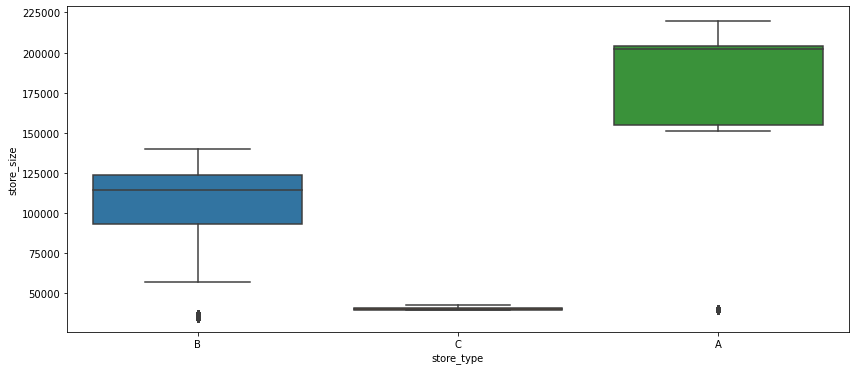

In [15]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='store_type', y='store_size', data=df)

In [16]:
#correct outlier store_types
def address_outliers():
    df.loc[df['store_id'] == 3].replace({'B':'C'})
    df.loc[df['store_id'] == 5].replace({'B':'C'})
    df.loc[df['store_id'] == 33].replace({'A':'C'})
    df.loc[df['store_id'] == 36].replace({'A':'C'})
    
    return df

In [17]:
df2= address_outliers()

<AxesSubplot:xlabel='store_type', ylabel='store_size'>

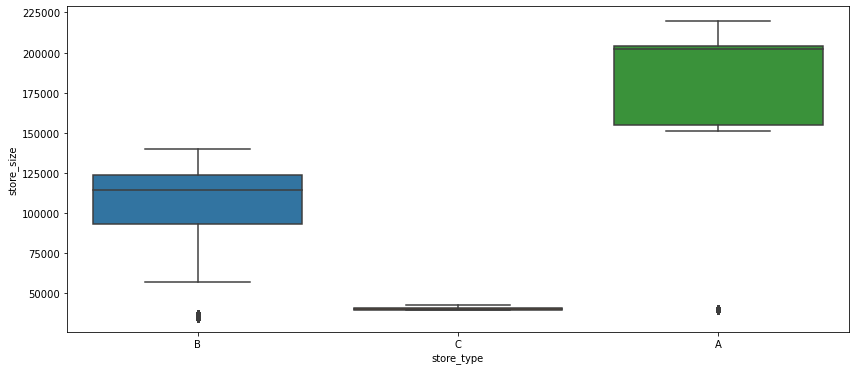

In [18]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='store_type', y='store_size', data=df2)

In [19]:
df.isnull().sum()

store_id           0
weekly_sales       0
holiday_flag       0
temperature        0
fuel_price         0
CPI                0
unemployment       0
store_type         0
store_size         0
month              0
year               0
quarter            0
weekday            0
week_of_week       0
deflated_series    0
sales_delta        0
gas_delta          0
season             0
dtype: int64

### Takeaways:
- Store A: appears to be only larger stores
- Store B: appear to be midsized stores
- Store C: appears to be only smaller stores

<AxesSubplot:xlabel='store_type', ylabel='weekly_sales'>

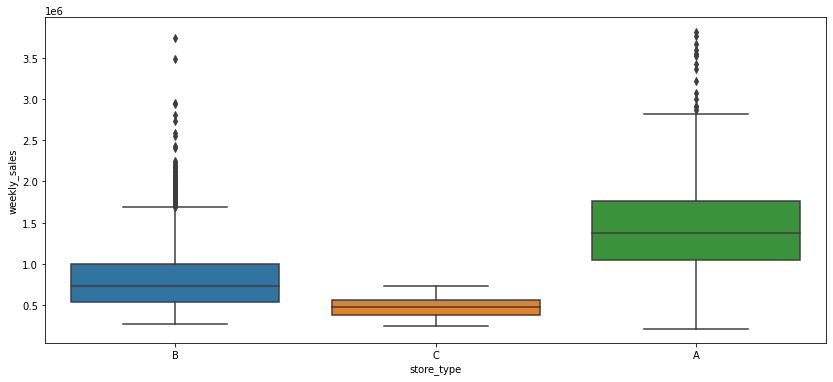

In [20]:
plt.figure(figsize=(14,6))
sns.boxplot(x='store_type', y='weekly_sales', data=df)